# PROJECT: Course Optimization for Data Science 2025-2026
## Optimization strategies for the "smoothed" quantile regression with (non-)smooth penalties

Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- Derive mathematically and implement the loss and gradient of a smoothed pinball loss used for quantile regression
- Implement your own solvers for L1 and L2 regularizations with: (Accelerated) Proximal gradient descent, proximal coordinate descent and L-BFGS (only for L2)
- Implement your own scikit-learn estimator for L1 or L2 regularized smoothed-quantile regression model and test it on a real dataset where we will look at prediction intervals.


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 11th of January 2026 at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [29]:
# Change here using YOUR first and last names
fn1 = "ralph"
ln1 = "mouawad"
fn2 = "charles"
ln2 = "karrer"

filename = "_".join(map(lambda s: s.strip().lower(),
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_mouawad_ralph_and_karrer_charles.ipynb


Some imports

In [30]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Part 1: Smoothed quantile regression model

[Quantile regression](https://en.wikipedia.org/wiki/Quantile_regression) is a supervised learning regression model with target space $\mathcal{Y} = \mathbb{R}$. It is a method widely used in statistics to obtain prediction intervals, and it is very often used in time series forecasting.

We consider observations $x \in \mathbb{R}^{P}$. $P$ is the number of features, and we will denote the $N$ observations available in the training set as $x_1, \dots, x_N$.

We consider a linear model, _i.e.,_ we want to learn the parameters $\theta = (w, b) \in \mathbb{R}^{P}\times \mathbb{R}$ such that the value of $w^\top x + b$ is the $\tau$-quantile of the conditional distribution $y | x$. For example, for $\tau=0.5$, we want to learn the parameters such that the value of $w^\top x + b$ is the *median* of the conditional distribution $y | x$. For $\tau=0.9$, we want to learn the parameters such that the value of $w^\top x + b$ is the *90th percentile* of the conditional distribution $y | x$, meaning that 90% of the observations of $y | x$ are below $w^\top x + b$.

An estimate $\hat{q}$ of the $\tau$-conditional sample quantile is obtained by minimizing the following loss function:
$$
\hat{q} = \arg\min_{q}
    \frac{1}{N} \sum_{i=1}^N
    \left[
            (\tau - 1) \mathbb{1}_{\{y_i < q\}} (y_i - q) +
            \tau \mathbb{1}_{\{y_i \geq q\}} (y_i - q)
    \right]
$$

The function $\ell_\tau(z) = (\tau - 1) \mathbb{1}_{\{z \leq 0\}} (z) + \tau \mathbb{1}_{\{z \geq 0\}} (z)$ is known as the **pinball loss**. The above loss can then be rewritten as:
$$
\hat{q} = \arg\min_{q}
    \frac{1}{N} \sum_{i=1}^N \ell_\tau(y_i - q) \enspace.
$$
The optimization problem becomes:
$$
\hat{w}, \hat{b} = \arg\min_{w, b} L(w, b)
    \enspace \mathrm{with} \enspace L(w, b) = \frac{1}{N} \sum_{i=1}^N \ell_\tau(y_i - w^\top x_i - b)
$$

Introducing some regularization on the parameter $w$ with parameter $\lambda \ge 0$, the penalized estimation problem is written:

$$
    (\mathcal{P}^{\mathcal{R}}):
	\min_{w \in \mathbb{R}^P, b \in \mathbb{R}} \quad L(w, b) + \lambda \mathcal{R}(w)
$$

where $\mathcal{R}(w)$ can be :
- $\mathcal{R}_1(w) = \|w\|_1 = \sum_{j=1}^P |w_{j}|$, ie. an $\ell_1$ norm
- $\mathcal{R}_2(w) = \|w\|_2^2 = \sum_{j=1}^P w_{j}^2$, ie. a squared $\ell_2$ norm

Here is an implementation of the pinball loss:

In [31]:
def pinball(z, tau=0.5):
    """Compute the pinball loss for z and a quantile tau.

    Parameters
    ----------
    z : ndarray, shape (n_samples,)
        The values on which to compute the pinball loss.
    tau : float in [0, 1]
        The quantile.

    Returns
    -------
    loss : ndarray, shape (n_samples,)
        The value of the pinball loss for each value of z.
    """
    sign = (z >= 0).astype(z.dtype)
    loss = tau * sign * z - (1 - tau) * (1 - sign) * z
    return loss

#### QUESTION 0

- Plot the pinball loss for tau=0.3, 0.5 and 0.7.

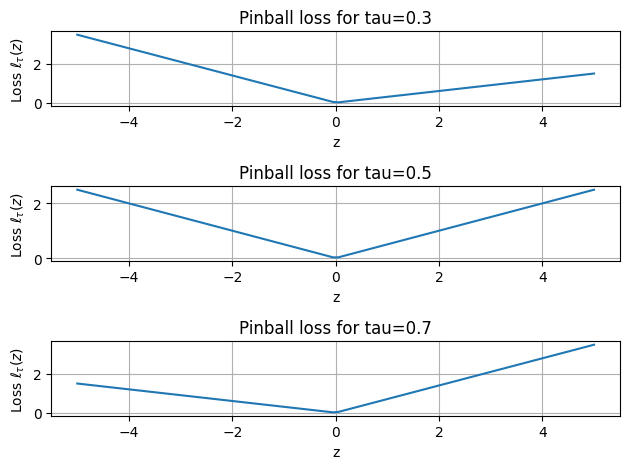

In [32]:
### TODO
L_tau = [0.3 , 0.5 , 0.7]
fig, ax = plt.subplots(3,1)
for i ,tau in enumerate(L_tau):
    z = np.linspace(-5,5,100)
    loss = pinball(z, tau)
    ax[i].plot(z, loss)
    ax[i].set_title(f"Pinball loss for tau={tau}")
    ax[i].set_xlabel("z")
    ax[i].set_ylabel(r'Loss $\ell_\tau(z)$')
    ax[i].grid()

plt.tight_layout()
plt.show()
### END TODO

#### QUESTION 1:

- Justify that $(\mathcal{P}^{\mathcal{R}_1})$ and $(\mathcal{P}^{\mathcal{R}_2})$ are convex optimization problems.
- Can you readily apply gradient descent or proximal gradient descent to solve these two problems? You will justify your answer by commenting on the smoothness of the objective functions.

INSERT YOUR ANSWER HERE
### 1. Convexity of $(\mathcal{P}^{\mathcal{R}_1})$ and $(\mathcal{P}^{\mathcal{R}_2})$

To justify that the optimization problems are convex, we must show that the objective function in both cases is a sum of convex functions.

**Convexity of the Pinball Loss**

The pinball loss function is defined as:
$$
\ell_\tau(z) = (\tau - 1)\,\mathbb{1}_{\{z \leq 0\}}\,z + \tau\,\mathbb{1}_{\{z \geq 0\}}\,z
$$

This can be rewritten as the pointwise maximum of two linear functions:
$$
\ell_\tau(z) = \max \left(\tau z,\; (\tau - 1) z\right)
$$

Since linear functions are convex and the pointwise maximum of convex functions preserves convexity, $\ell_\tau$ is a convex function.

**Convexity of the Data-Fitting Term**

The term inside the loss is
$
z_i = y_i - w^\top x_i - b
$
which is an affine transformation of the variables $(w,b)$. Then, because the composition of a convex function with an affine mapping is convex,
$
\ell_\tau\!\left(y_i - w^\top x_i - b\right)
$
is convex with respect to $(w,b)$. Since $L(w,b)$ is a sum (with non-negative weights $\frac{1}{N}$) of these convex terms, $L(w,b)$ is convex:
$$
L(w,b) = \frac{1}{N}\sum_{i=1}^{N}\ell_\tau\!\left(y_i - w^\top x_i - b\right).
$$

**Convexity of the Regularizers**

- $\mathcal{R}_1(w) = \lVert w\rVert_1$: This is a norm. By definition (triangle inequality and homogeneity), all norms are convex functions.

- $\mathcal{R}_2(w) = \lVert w\rVert_2^2$: This is a quadratic function with a Hessian matrix equal to $2I$ (where $I$ is the identity matrix). Since the Hessian is positive definite, the function is strictly convex.

Hence, both optimization problems $(\mathcal{P}^{\mathcal{R}_1})$ and $(\mathcal{P}^{\mathcal{R}_2})$ consist of minimizing the positive sum of a convex loss function $L(w,b)$ and a convex regularizer ($\lambda\mathcal{R}_1$ or $\lambda\mathcal{R}_2$). Since the sum of convex functions is convex, both problems are convex optimization problems.

---

### 2. Applicability of Gradient Descent and Proximal Gradient Descent

To determine if we can apply these algorithms, we must analyze the smoothness of the objective functions.

**Analysis of Smoothness**

- The loss $L(w,b)$: The pinball loss
$
\ell_\tau(z) = \max\left(\tau z,\; (\tau - 1)z\right)
$
has a point of non-differentiability at $z = 0$. Consequently, the aggregate loss $L(w,b)$ is non-smooth (non-differentiable) whenever any residual $y_i - w^\top x_i - b$ is exactly zero.

- The regularizer $\mathcal{R}_1(w)$: The $\ell_1$ norm is non-smooth at any point where at least one coordinate $w_j = 0$.

- The regularizer $\mathcal{R}_2(w)$: The squared $\ell_2$ norm is smooth (differentiable everywhere).

Gradient Descent requires the objective function to be differentiable everywhere to compute the gradient $\nabla F(w,b)$. Because the loss function $L(w,b)$ is non-smooth (and $\mathcal{R}_1$ is also non-smooth), the gradient is undefined at certain points. Hence we cannot apply it.

Proximal Gradient Descent is designed to minimize objectives of the form
$$
F(x) = f(x) + g(x),
$$
where:
1. $f(x)$ is smooth (differentiable with a Lipschitz-continuous gradient),
2. $g(x)$ is convex and prox-friendly (easy to compute the proximal operator).

In our case, we typically treat the data-fitting loss $L(w,b)$ as $f(x)$ and the regularizer as $g(x)$. However, since $L(w,b)$ is non-smooth, it cannot serve as the smooth part $f(x)$ for the gradient step. Therefore, standard proximal gradient descent cannot be readily applied.


Let us illustrate what type of solution one obtains when minimizing the pinball loss. For now, we will use a black-box optimization method from `scipy`.

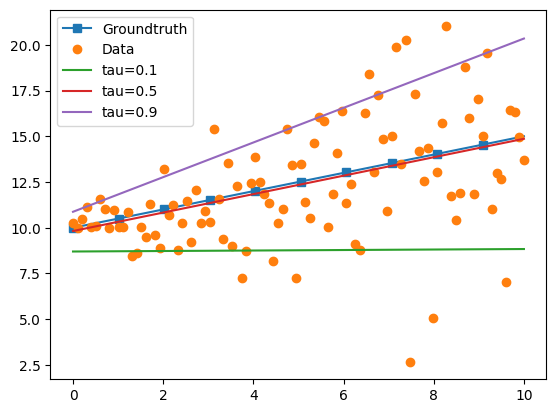

In [33]:
import numpy as np
from scipy.optimize import minimize

rng = np.random.RandomState(42)
x = np.linspace(start=0, stop=10, num=100)
X = x[:, np.newaxis]  # make X two-dimensional with one column
y_true = 10 + 0.5 * x
y = y_true + rng.normal(loc=0, scale=0.5 + 0.5 * x, size=x.shape[0])

plt.plot(x, y_true, "s-", label='Groundtruth', markevery=10)
plt.plot(x, y, 'o', label="Data")
tau = 0.3

def pobj(wb, tau):
    w, b = wb[:1], wb[-1]
    return np.mean(pinball(y - X @ w - b, tau=tau))

for tau in [0.1, 0.5, 0.9]:
    w_hat, b_hat = minimize(lambda wb : pobj(wb, tau), x0=[0, 0]).x
    plt.plot(x, x * w_hat + b_hat, label=f"tau={tau}")

plt.legend()
plt.show()

One can observe that the predictions obtained with 0.1 and 0.9 form an interval that can be used to evaluate the uncertainty of the prediction.

## Smoothed pinball loss

Let us define the function:

$$
    \ell_\tau^\delta(z) = \min_{u \in \mathbb{R}} \quad
    \underbrace{
        \ell_\tau(u) + \tfrac{1}{2\delta} (z - u)^2
    }_{J(u)}
$$

#### QUESTION 2:
- Justify that the function $\ell_\tau^\delta: z \rightarrow \ell_\tau^\delta(z)$ is well defined, meaning that a unique function value exists for each value of z.
- Prove that for any $\delta >0$, we have $\ell_\tau^\delta(z) \leq \ell_\tau(z)$.
- Prove that the function $\ell_\tau^\delta$ is given by the formula just below:

$$
    \ell_\tau^\delta (z) = \left\{
	\begin{aligned}
	\tau (z - \frac{\delta \tau}{2}) & \quad \mathrm{ if } \quad  \delta \tau \leq z \\
	\frac{z^2}{2 \delta} & \quad \mathrm{ if } \quad 0 \leq z < \tau \delta \\
	\frac{z^2}{2 \delta} & \quad \mathrm{ if } \quad  -\delta (1 - \tau) \leq z < 0 \\
    (1-\tau) \left( -z - \tfrac{\delta}{2} (1 - \tau) \right) & \quad \mathrm{ otherwise }
	\end{aligned}
    \right.
$$

INSERT YOUR ANSWER HERE

We fix $z \in \mathbb{R}$ and $\delta > 0$, and define
$$
J(u) = \ell_\tau(u) + \frac{1}{2\delta}(z-u)^2, \qquad u \in \mathbb{R}.
$$

### 1) Well-definedness of $\ell_\tau^\delta(z)$ (existence and uniqueness)

We show that
$$
\ell_\tau^\delta(z) = \min_{u\in\mathbb{R}} J(u)
$$
is well defined, i.e. the minimum exists and is unique.

#### a) Existence of a minimizer

- $\ell_\tau$ is finite everywhere and convex, hence continuous on $\mathbb{R}$.
- The function $u \mapsto \dfrac{1}{2\delta}(z-u)^2$ is continuous and satisfies
  $$
  \frac{1}{2\delta}(z-u)^2 \to +\infty \quad \text{as } |u| \to \infty.
  $$
- Therefore $J(u) \to +\infty$ as $|u| \to \infty$ (the quadratic dominates the linear growth), so $J$ is coercive.
- Since $\mathbb{R}$ is closed and $J$ is continuous and coercive, $J$ attains its minimum on $\mathbb{R}$.

Thus, there exists $u^*(z)\in\mathbb{R}$ such that
$$
J\bigl(u^*(z)\bigr) = \min_{u\in\mathbb{R}} J(u).
$$

#### b) Uniqueness of the minimizer

- $\ell_\tau$ is convex.
- The function $u \mapsto \dfrac{1}{2\delta}(z-u)^2$ is $(1/\delta)$-strongly convex since $f''(u)=1/\delta$.
- The sum of a convex function and a $(1/\delta)$-strongly convex function is $(1/\delta)$-strongly convex.

Hence $J$ is strongly convex on $\mathbb{R}$, and a strongly convex function admits at most one minimizer.

In conclusion, for every $z\in\mathbb{R}$, there exists a unique minimizer $u^*(z)$. Therefore the value
$$
\ell_\tau^\delta(z) = J\bigl(u^*(z)\bigr)
$$
is uniquely defined, and the function $\ell_\tau^\delta : z \mapsto \ell_\tau^\delta(z)$ is well defined.

---

### 2) Inequality $\ell_\tau^\delta(z) \le \ell_\tau(z)$

For any $\delta>0$, we show that
$$
\ell_\tau^\delta(z) \le \ell_\tau(z).
$$

By definition,
$$
\ell_\tau^\delta(z) = \min_{u\in\mathbb{R}} \left[\ell_\tau(u) + \frac{1}{2\delta}(z-u)^2\right].
$$
In particular, for $u=z$,
$$
\ell_\tau^\delta(z) \le \ell_\tau(z) + \frac{1}{2\delta}(z-z)^2 = \ell_\tau(z).
$$

The quadratic term penalizes moving away from $z$ but we are allowed to choose $u=z$. So this smoothing term either leaves the error unchanged or lowers it.

---

### 3) Value of $\ell_\tau^\delta(z)$

The goal is to find the minimum of $J(u)$. Since $J$ is convex, we can use the subgradient optimality condition:
$u^*$ minimizes the convex function $J$ iff $0 \in \partial J(u^*)$.

Now,
$$
\partial J(u) = \partial \ell_\tau(u) + \partial\!\left[\frac{1}{2\delta}(z-u)^2\right].
$$
Since the quadratic term is differentiable,
$$
\partial\!\left[\frac{1}{2\delta}(z-u)^2\right] = \left\{\frac{1}{\delta}(u-z)\right\}.
$$
Hence the optimality condition is
$$
0 \in \partial \ell_\tau(u^*) + \frac{1}{\delta}(u^* - z)
\quad \Longleftrightarrow \quad
\frac{z-u^*}{\delta} \in \partial \ell_\tau(u^*). \tag{*}
$$

The next step is to compute the subdifferential of the pinball loss. For $\tau\in[0,1]$,
$$
\ell_\tau(u)=
\begin{cases}
(\tau-1)u & \text{if } u<0,\\
0 & \text{if } u=0,\\
\tau u & \text{if } u>0.
\end{cases}
$$
Thus,
$$
\partial \ell_\tau(u)=
\begin{cases}
\{\tau-1\} & \text{if } u<0,\\
[\tau-1,\tau] & \text{if } u=0,\\
\{\tau\} & \text{if } u>0.
\end{cases}
$$

Let us use $(*)$ by cases.

#### Case 1: $u^*>0$

Then $\partial \ell_\tau(u^*)=\{\tau\}$. Condition $(*)$ gives
$$
\frac{z-u^*}{\delta}=\tau
\quad \Longrightarrow \quad
u^* = z-\delta\tau.
$$
The constraint $u^*>0$ means $z-\delta\tau>0$, i.e. $z>\delta\tau$ (and $z=\delta\tau$ gives $u^*=0$, handled below).

Value:
$$
\ell_\tau^\delta(z)=\ell_\tau(u^*)+\frac{1}{2\delta}(z-u^*)^2
= \tau(z-\delta\tau)+\frac{1}{2\delta}(\delta\tau)^2
= \tau z - \frac{\delta\tau^2}{2}
= \tau\!\left(z-\frac{\delta\tau}{2}\right),
$$
valid for $z \ge \delta\tau$.

- for $z \ge \delta\tau$,
  $$
  \ell_\tau^\delta(z)=\tau\!\left(z-\frac{\delta\tau}{2}\right).
  $$

#### Case 2: $u^*<0$

Then $\partial \ell_\tau(u^*)=\{\tau-1\}$. Condition $(*)$ gives
$$
\frac{z-u^*}{\delta}=\tau-1
\quad \Longrightarrow \quad
u^* = z+\delta(1-\tau).
$$
The constraint $u^*<0$ means $z+\delta(1-\tau)<0$, i.e. $z<-\delta(1-\tau)$ (boundary handled below).

Value:
$$
\ell_\tau^\delta(z)=(\tau-1)u^*+\frac{1}{2\delta}(z-u^*)^2
= (\tau-1)\bigl(z+\delta(1-\tau)\bigr)+\frac{1}{2\delta}\bigl(\delta(1-\tau)\bigr)^2
$$
$$
= (1-\tau)(-z) - \frac{\delta(1-\tau)^2}{2}
= (1-\tau)\!\left(-z-\frac{\delta}{2}(1-\tau)\right),
$$
valid for $z \le -\delta(1-\tau)$.

- for $z < -\delta(1-\tau)$,
  $$
  \ell_\tau^\delta(z)=(1-\tau)\!\left(-z-\frac{\delta}{2}(1-\tau)\right).
  $$

#### Case 3: $u^*=0$

Then $\partial \ell_\tau(0)=[\tau-1,\tau]$. Condition $(*)$ becomes
$$
\frac{z}{\delta}\in[\tau-1,\tau]
\quad \Longleftrightarrow \quad
z \in \bigl[-\delta(1-\tau),\,\delta\tau\bigr].
$$

Value:
$$
\ell_\tau^\delta(z)=\ell_\tau(0)+\frac{1}{2\delta}z^2=\frac{z^2}{2\delta},
$$
valid for $-\delta(1-\tau)\le z \le \delta\tau$. By splitting this interval, we have:
- for $0 \le z < \delta\tau$,
  $$
  \ell_\tau^\delta(z)=\frac{z^2}{2\delta},
  $$
- for $-\delta(1-\tau)\le z < 0$,
  $$
  \ell_\tau^\delta(z)=\frac{z^2}{2\delta}.
  $$

In conclusion we have the exact formula indicatted above


#### QUESTION 3:
- Implement the function `smooth_pinball(z, tau, delta)` that applies $\ell_\tau^\delta$ to each entry a numpy array. You will plot the function `smooth_pinball` and `pinball` between -2 and 2.

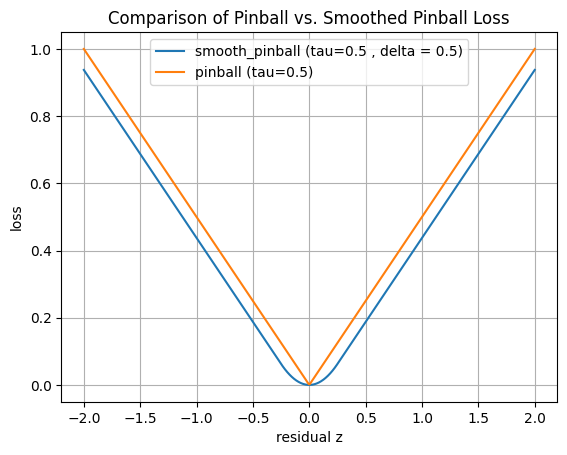

In [34]:
from numpy import sign


def smooth_pinball(z, tau, delta):
    """Compute the smoothed pinball loss

    Parameters
    ----------
    z : array-like, shape (n_samples,)
        The array on which to compute the smoothed pinball loss.
    tau : float in [0, 1]
        The quantile.
    delta : float
        The smoothing parameter.

    Returns
    -------
    l : array-like, shape (n_samples,)
        The smoothed pinball loss values.
    """
    out = z.copy().astype(np.float64)
    ### TODO
    z = np.asarray(z, dtype=np.float64)
    out = np.empty_like(z)

    m1 = z >= delta * tau
    m2 = (z >= 0) & (z < delta * tau)
    m3 = (z >= -delta * (1 - tau)) & (z < 0)
    m4 = z < -delta * (1 - tau)

    out[m1] = tau * (z[m1] - 0.5 * delta * tau)
    out[m2] = (z[m2] ** 2) / (2 * delta)
    out[m3] = (z[m3] ** 2) / (2 * delta)
    out[m4] = (1 - tau) * (-z[m4] - 0.5 * delta * (1 - tau))
    ### END TODO
    return out

### TODO plotting
Liste_z = np.linspace(-2, 2, 400)

l1 = smooth_pinball(Liste_z, tau=0.5, delta=0.5)
l2 = pinball(Liste_z, tau=0.5)

plt.plot(Liste_z, l1, label="smooth_pinball (tau=0.5 , delta = 0.5)")
plt.plot(Liste_z, l2, label="pinball (tau=0.5)")

plt.grid()
plt.xlabel("residual z")
plt.ylabel("loss")
plt.title("Comparison of Pinball vs. Smoothed Pinball Loss")
plt.legend()
plt.show()
### END TODO

#### QUESTION 4:
- What is the derivative of the smoothed pinball loss $\ell_\tau^\delta$?
- Justify that the derivative of the smoothed pinball loss is continuous.
- Justify that the function $\ell_\tau^\delta$ is L-smooth. Propose a value for the Lipschitz constant of its gradient.
- Justify that the function $\ell_\tau^\delta$ is convex. Is it strongly convex?
- Implement the function `grad_smooth_pinball(z, tau, delta)` that applies the derivative of $\ell_\tau^\delta$ to each entry of a numpy array.

**Remark:** You will use the `scipy.optimize.check_grad` function to assess the validity of your result. You will need to test your gradient in both the linear and quadratic regions of the function (not just in one location).

### 1. Derivative of the smoothed pinball loss $\ell_\tau^\delta$

Using the piecewise expression of $\ell_\tau^\delta(z)$, we differentiate on each region.

- **If $z \ge \delta\tau$ :**  

  $
  \ell_\tau^\delta(z) = \tau\!\left(z - \frac{\delta\tau}{2}\right),
  $
  hence
  $
  (\ell_\tau^\delta)'(z) = \tau.
  $


- **If $0 \le z < \delta\tau$ :**  

  $
  \ell_\tau^\delta(z) = \frac{z^2}{2\delta},
  $
  hence
  $
  (\ell_\tau^\delta)'(z) = \frac{z}{\delta}.
  $


- **If $-\delta(1-\tau) \le z < 0$ :**  

  $
  \ell_\tau^\delta(z) = \frac{z^2}{2\delta},
  $
  hence
  $
  (\ell_\tau^\delta)'(z) = \frac{z}{\delta}.
  $


- **If $z < -\delta(1-\tau)$ :**  

  $
  \ell_\tau^\delta(z) = (1-\tau)\!\left(-z - \frac{\delta}{2}(1-\tau)\right),
  $
  hence
  $
  (\ell_\tau^\delta)'(z) = -(1-\tau).
  $

  
Therefore, the derivative can be summarized as
$$
(\ell_\tau^\delta)'(z)=
\begin{cases}
-(1-\tau), & \text{if } z < -\delta(1-\tau),\\[4pt]
\dfrac{z}{\delta}, & \text{if } -\delta(1-\tau) \le z \le \delta\tau,\\[6pt]
\tau, & \text{if } z > \delta\tau.
\end{cases}
$$

---

### 2. Continuity of the derivative

We check continuity at the two junction points.

- **At $z = \delta\tau$**  
  From the middle region,
  $$
  \frac{z}{\delta} = \frac{\delta\tau}{\delta} = \tau,
  $$
  and from the right region,
  $$
  (\ell_\tau^\delta)'(z) = \tau.
  $$
  The one-sided limits coincide.

- **At $z = -\delta(1-\tau)$**  
  From the left region,
  $$
  (\ell_\tau^\delta)'(z) = -(1-\tau),
  $$
  and from the middle region,
  $$
  \frac{z}{\delta} = \frac{-\delta(1-\tau)}{\delta} = -(1-\tau).
  $$
  The one-sided limits coincide.

Hence $(\ell_\tau^\delta)'$ is continuous on $\mathbb{R}$.

---

### 3. $L$-smoothness and Lipschitz constant

A one-dimensional function is $L$-smooth if its derivative is $L$-Lipschitz, i.e.
$$
\bigl|(\ell_\tau^\delta)'(z_1) - (\ell_\tau^\delta)'(z_2)\bigr|
\le L\,|z_1 - z_2| \quad \text{for all } z_1,z_2.
$$

Here, $(\ell_\tau^\delta)'(z)$ is
- constant outside the interval $\bigl[-\delta(1-\tau),\,\delta\tau\bigr]$,
- linear with slope $1/\delta$ inside this interval.

Thus, the largest slope of $(\ell_\tau^\delta)'$ is $1/\delta$, which implies that $(\ell_\tau^\delta)'$ is $(1/\delta)$-Lipschitz. Therefore, $\ell_\tau^\delta$ is $L$-smooth with
$$
L = \frac{1}{\delta}.
$$

---

### 4. Convexity and strong convexity

**Convexity.**  
The derivative $(\ell_\tau^\delta)'(z)$ is non-decreasing on $\mathbb{R}$: it is constant on the left, increases linearly on $\bigl[-\delta(1-\tau),\,\delta\tau\bigr]$, and is constant on the right. Hence $\ell_\tau^\delta$ is convex.

**Strong convexity.**  
The function $\ell_\tau^\delta$ is not strongly convex on $\mathbb{R}$. Outside the central interval, the function is affine (constant slope), so the curvature is zero there. Strong convexity would require a uniform positive curvature $\mu>0$ everywhere, which is not satisfied.


Gradient check error: 5.555383087067107e-09


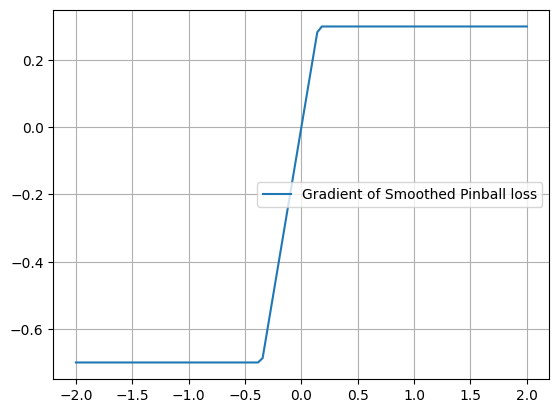

In [35]:
def grad_smooth_pinball(z, tau, delta):
    """Compute the derivative of the smoothed pinball loss

    Parameters
    ----------
    z : array-like, shape (n_samples,)
        The array on which to compute the smoothed pinball loss.
    tau : float in [0, 1]
        The quantile.
    delta : float
        The smoothing parameter.

    Returns
    -------
    dl : array-like, shape (n_samples,)
        The derivative of smoothed pinball loss computed element-wise.
    """
    out = z.copy().astype(np.float64)
    ### TODO
    z = np.asarray(z, dtype=np.float64)
    out = np.empty_like(z)

    m1 = z < -delta * (1 - tau)
    m2 = (z >= -delta * (1 - tau)) & (z <= delta * tau)
    m3 = z > delta * tau

    out[m1] = -(1 - tau)
    out[m2] = z[m2] / delta
    out[m3] = tau
    ### END TODO
    return out

x = np.linspace(-2, 2, 100)
tau = 0.3
plt.grid()
plt.plot(x, grad_smooth_pinball(x, tau=tau, delta=.5), label='Gradient of Smoothed Pinball loss')
plt.legend();

from scipy.optimize import check_grad

### TODO check gradient with check_grad function.
def f(z):
    return np.mean(smooth_pinball(z, tau=tau, delta=0.5))

def grad_f(z):
    return grad_smooth_pinball(z, tau=tau, delta=0.5) / z.size

z0 = np.linspace(-1, 1, 10)
err = check_grad(f, grad_f, z0)
print("Gradient check error:", err)
### END TODO

The gradient error is near zero (around 1e-10), indicating that the implementation of the gradient is correct.

From now on, we consider the following optimization problem:

$$
    (\mathcal{P}_\delta^\mathcal{R}): \min_{w, b} \quad L_\delta(w, b) + \lambda \mathcal{R}(w)
$$

where $\mathcal{R}(w)$ can be $\mathcal{R}_1(w)$ or $\mathcal{R}_2(w)$, and where $L_\delta(w, b) = \frac{1}{N} \sum_{i=1}^N \ell_\tau^\delta(y_i - w^\top x_i - b)$.

#### QUESTION 5:
- Justify what optimization strategy among L-BFGS, (proximal-)gradient descent, (proximal-)coordinate descent is readily applicable
  for $(\mathcal{P}_\delta^{\mathcal{R}_2})$ and $(\mathcal{P}_\delta^{\mathcal{R}_1})$.

INSERT YOUR ANSWER HERE

We consider the optimization problem
$$
(\mathcal{P}_\delta^{\mathcal{R}}):\quad \min_{w,b}\; L_\delta(w,b) + \lambda\,R(w),
$$
where $L_\delta$ is built from the smoothed pinball loss $\ell_\tau^\delta$.

Since $\ell_\tau^\delta$ is differentiable with a Lipschitz-continuous derivative, the data-fitting term
$$
L_\delta(w,b) = \frac{1}{N}\sum_{i=1}^{N}\ell_\tau^\delta\!\left(y_i - w^\top x_i - b\right)
$$
is a smooth function of $(w,b)$.

If we consider the regularizer $\mathcal{R}_1$, the appropriate general optimization strategy
is to use proximal methods, since $\mathcal{R}_1(w)=\lVert w\rVert_1$ is convex but non-smooth. In this case,
proximal gradient descent (and also proximal coordinate descent) is readily applicable.

If we restrict to the case $\mathcal{R}_2(w)=\lVert w\rVert_2^2$ only, then the whole objective
$$
L_\delta(w,b) + \lambda\,\lVert w\rVert_2^2
$$
is smooth. Therefore standard gradient / coordinate descent and L-BFGS can be
applied directly, without any proximal step (or prox R2). However coordinate and Standard Gradient Descent converges slowly compared to L-BFGS. Therefore, L-BFGS is the most efficient and standard choice for this smooth convex problem.

In summary:
- for $k = 1$: proximal gradient descent is applicable;
- for $k = 2$ All methods are applicable, and L-BFGS is the best choice


#### QUESTION 6:
- Solve the optimization prolem $(\mathcal{P}_\delta^{\mathcal{R}_2})$ using the `fmin_l_bfgs_b` function from `scipy.optimize`. You are expected to provide the explicit gradient (fprime parameter) to `fmin_l_bfgs_b`.
- Using the simulated dataset from above, you will check that your solver gives comparable results as obtained above without smoothing when setting a very small value for $\lambda$. Your are expected to make a plot of the regression fit.

The estimate of $w$ and $b$ should be called `w_hat` and `b_hat`. You will call the regularization parameter $\lambda$ as `lbda` in the code.

To help you, we provide you with the function `pobj_l2` that computes the objective to minimize. Note that the parameters `w` and `b` are combined in a single array `params`.

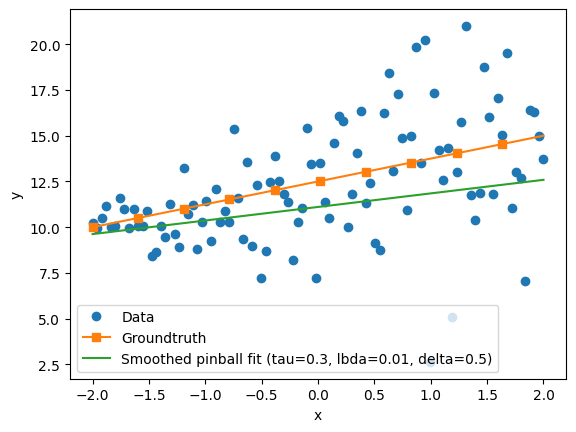

In [36]:
from scipy.optimize import fmin_l_bfgs_b

lbda = 0.01
delta = 0.5

def pobj_l2(params, X=X, y=y, lbda=lbda, tau=tau, delta=delta):
    """Objective function with L2 penalty."""
    w = params[1:]
    b = params[0]
    residual = y - np.dot(X, w) - b
    return np.mean(smooth_pinball(residual, tau=tau, delta=delta)) + lbda * np.sum(w ** 2)


def grad_pobj_l2(params, X=X, y=y, lbda=lbda, tau=tau, delta=delta):
    """Explicit gradient of pobj_l2 wrt params = [b, w]."""
    b = params[0]
    w = params[1:]
    n = y.shape[0]

    residual = y - X @ w - b                       # shape (n,)
    dloss = grad_smooth_pinball(residual, tau, delta)  # d/d(residual) ℓ_τ^δ(residual), shape (n,)

    # chain rule: residual = y - Xw - b  => dr/db = -1, dr/dw = -X
    grad_b = -np.mean(dloss)                       # scalar
    grad_w = -(X.T @ dloss) / n + 2 * lbda * w     # shape (p,)

    return np.r_[grad_b, grad_w]

def smooth_pinball_lbfgs_l2(X=X, y=y, lbda=lbda, tau=tau, delta=delta):
    """Estimate w and b using L-BFGS.

    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
        The array of features.
    y : ndarray, shape (n_samples,)
        The target.
    lbda : float
        The regularization parameter lbda
    tau : float in [0, 1]
        The quantile.
    delta : float
        The smoothing parameter.

    Returns
    -------
    w_hat : ndarray, shape (n_features,)
        The estimated w.
    b_hat : float
        The estimated b.
    """
    # TODO
    p = X.shape[1]
    x0 = np.zeros(p + 1)  # params = [b, w]

    params_hat, f_hat, info = fmin_l_bfgs_b(
        func=lambda params: pobj_l2(params, X=X, y=y, lbda=lbda, tau=tau, delta=delta),
        x0=x0,
        fprime=lambda params: grad_pobj_l2(params, X=X, y=y, lbda=lbda, tau=tau, delta=delta),
        maxiter=1000
    )

    b_hat = params_hat[0]
    w_hat = params_hat[1:]
    # END TODO
    return w_hat, b_hat


w_hat, b_hat = smooth_pinball_lbfgs_l2(X, y, lbda=0.01, tau=0.3, delta=0.5)
y_pred = np.dot(X, w_hat) + b_hat

# TODO  (visualization of the fit)
plt.figure()
plt.plot(x, y, "o", label="Data")
plt.plot(x, y_true, "s-", label="Groundtruth", markevery=10)
plt.plot(x, y_pred, label=f"Smoothed pinball fit (tau={tau}, lbda={lbda}, delta={delta})")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# END TODO

The smoothed pinball regression with τ=0.3 correctly estimates a lower conditional quantile, resulting in a line below the conditional mean. The deviation from the ground truth increases with
𝑥 due to heteroscedastic noise. The smoothing parameter ensures numerical stability and allows efficient optimization with L-BFGS, while mild
ℓ2 regularization yields a stable and smooth solution.

## Part 2: Smooth quantile regression with L1 regularization

In this section we are interested in the $\ell_1$ regularized model.
To help you we give you the code of the objective function to minimize.

In [9]:
def pobj_l1(params, X=X, y=y, lbda=lbda, tau=tau, delta=delta):
    w = params[1:]
    b = params[0]
    return np.mean(smooth_pinball(y - np.dot(X, w) - b, tau=tau, delta=delta)) + lbda * np.sum(np.abs(w))

Now that we have the cost function, you are going to implement solvers based on:

- Proximal Gradient Descent (PGD aka ISTA)
- Accelerated Proximal Gradient Descent (APGD aka FISTA)
- Proximal Coordinate Descent (PCD)

Before this we are going to define the `monitor` class previously used in the second lab as well as plotting functions useful to monitor convergence.

In [10]:
class monitor(object):
    def __init__(self, algo, obj, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.obj = obj
        self.args = args
        if self.x_min is not None:
            self.f_min = obj(x_min, *args)

    def run(self, *algo_args, **algo_kwargs):
        t0 = time.time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time.time() - t0
        self.x_list = x_list
        if self.x_min is not None:
            self.err = [linalg.norm(x - self.x_min) for x in x_list]
            self.obj = [self.obj(x, *self.args) - self.f_min for x in x_list]
        else:
            self.obj = [self.obj(x, *self.args) for x in x_list]


def plot_epochs(monitors, solvers):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    for monit in monitors:
        ax1.semilogy(monit.obj, lw=2)
        ax1.set_title("Objective")
        ax1.set_xlabel("Epoch")
        if monit.x_min is None:
            ax1.set_ylabel("$f(x_k)$")
        else:
            ax1.set_ylabel("$f(x_k) - f(x^*)$")

    ax1.legend(solvers)

    for monit in monitors:
        if monit.x_min is not None:
            ax2.semilogy(monit.err, lw=2)
            ax2.set_title("Distance to optimum")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("$\|x_k - x^*\|_2$")

    ax2.legend(solvers)


def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

<>:40: SyntaxWarning: invalid escape sequence '\|'
<>:40: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipython-input-307692320.py:40: SyntaxWarning: invalid escape sequence '\|'
  ax2.set_ylabel("$\|x_k - x^*\|_2$")


#### QUESTION 7a:
- Implement the proximal gradient descent (PGD) method.

**Note:**  The parameter `step` is the size of the gradient step that you will need to propose by computing the Lipschitz constant of the data fitting term (Smooth pinball term without regularization term).

In [11]:
def pgd(x_init, grad, prox, step, n_iter=100, store_every=1,
        grad_args=(), prox_args=()):
    """Proximal gradient descent algorithm.

    Parameters
    ----------
    x_init : array, shape (n_parameters,)
        Parameters of the optimization problem.
    grad : callable
        The gradient of the smooth data fitting term.
    prox : callable
        The proximal operator of the regularization term.
    step : float
        The size of the gradient step done on the smooth term.
    n_iter : int
        The number of iterations.
    store_every : int
        At which frequency should the current iterated be remembered.
    grad_args : tuple
        Parameters to pass to grad.
    prox_args : tuple
        Parameters to pass to prox.

    Returns
    -------
    x : array, shape (n_parameters,)
        The estimated parameters.
    x_list : list
        The list if x values along the iterations.
    """
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x = prox(x - step*grad(x, *grad_args), step, *prox_args)
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

#### QUESTION 7b:</b>
- Implement the L1 and L2 proximal operators. You will pay attention to the intercept.
- Using the monitor class and the plot_epochs function, display the convergence.

In order to get a good value of `x_min` you will let your PGD solver run for 10000 iterations.

First you will need to implement the proximal operator functions for $\ell_1$ and $\ell_2$ regularized models.

The proximal operator of the L2 norm is given by:

$$prox_{\lambda R_2}(x) = \frac{x}{1+2\lambda}$$

The proximal operator of the L1 norm is given by:

$$prox_{\lambda R_1}(x) = sign(x)max(0, |x| - \lambda)$$

In [12]:
def prox_R2(params, reg=1.):
    # TODO
    params[1:] = params[1:] / (1 + 2 * reg)
    # END TODO
    return params


def prox_R1(params, reg=1.):
    # TODO
    # params[0] = np.sign(params[0]) * max(0, np.abs(params[0]) - reg)
    params[1:] = np.sign(params[1:]) * np.maximum(0, np.abs(params[1:]) - reg)
    # END TODO
    return params


def prox_l2(params, step, lbda):
    return prox_R2(params, reg=step * lbda)


def prox_l1(params, step, lbda):
    return prox_R1(params, reg=step * lbda)

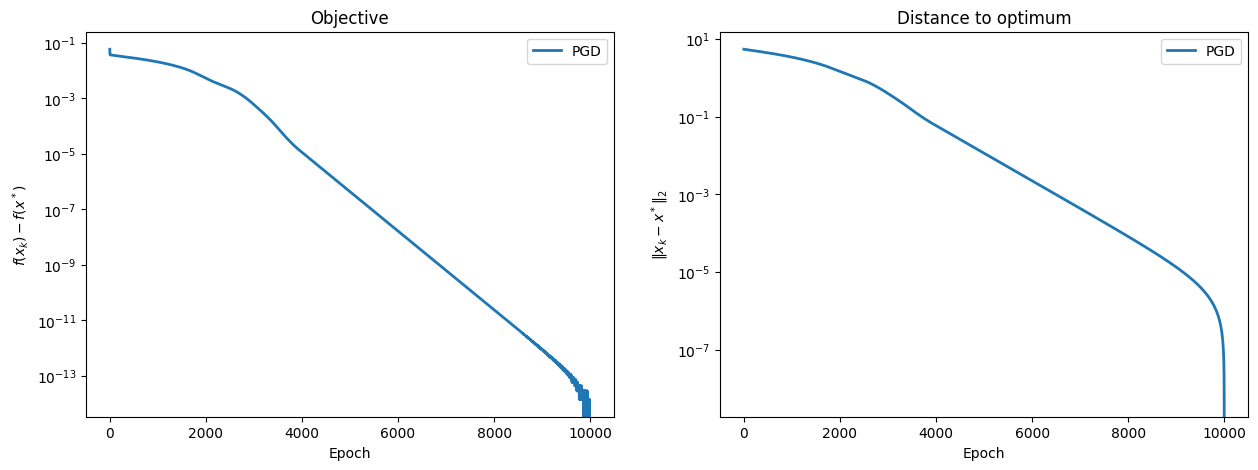

In [13]:
# Generate bigger data
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=500, n_features=100, random_state=0,
                       noise=4.0, bias=10.0)
n_samples, n_features = X.shape

# Set initial values of parameters to optimize
x_init = np.zeros(n_features + 1)
x_init[0] = np.mean(y)
n_iter = 10_000
lbda = 1
delta = 0.5
tau = 0.5

# TODO (implement function grad_smooth_pinball_loss and define step)
def grad_smooth_pinball_loss(params, X, y, tau, delta):

    b = params[0]
    w = params[1:]
    n = y.shape[0]

    residual = y - X @ w - b                       # shape (n,)
    dloss = grad_smooth_pinball(residual, tau, delta)  # d/d(residual) ℓ_τ^δ(residual), shape (n,)

    # chain rule: residual = y - Xw - b  => dr/db = -1, dr/dw = -X
    grad_b = -np.mean(dloss)                       # scalar
    grad_w = -(X.T @ dloss) / n

    return np.concatenate(([grad_b], grad_w))

# Spectral norm of X
L = (np.linalg.norm(X, ord=2) ** 2) / (n_samples * delta) ## lipschitz constant
step = 1.0 / L

# END TODO

# Get a good x_min by letting the algorithm converge with many iterations
x_min, _ = pgd(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter=10000, store_every=1000,
               grad_args=(X, y, tau, delta), prox_args=(lbda,))

# Run PGD
monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min, args=(X, y, lbda, tau, delta))
monitor_pgd_l2.run(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))

monitors = [monitor_pgd_l2]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

Now for the $\ell_1$ regularization:

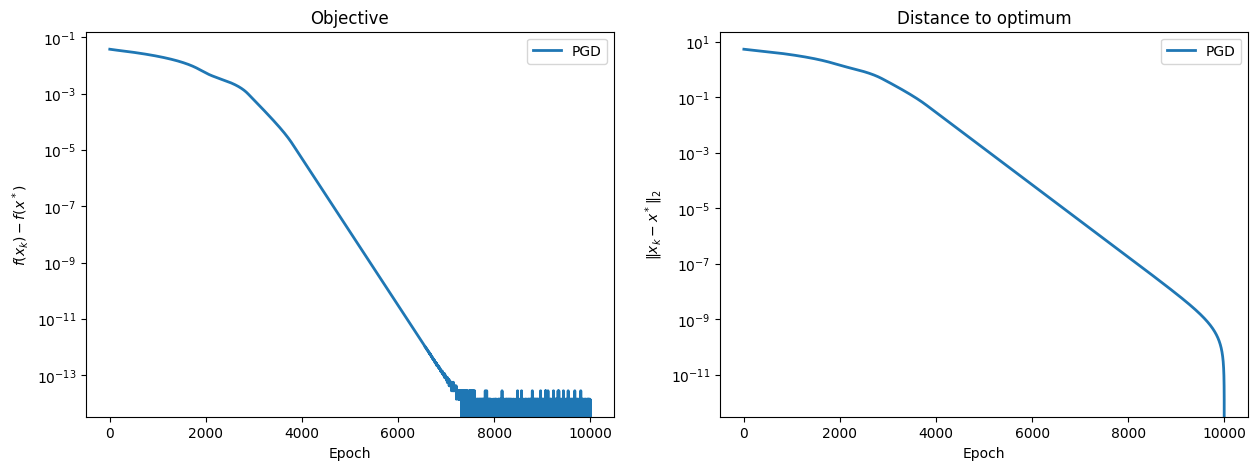

In [14]:
# Run PGD for L1

x_min_l1, _ = pgd(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter=10000, store_every=1000,
               grad_args=(X, y, tau, delta), prox_args=(lbda,))
monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, tau, delta))
monitor_pgd_l1.run(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))

monitors = [monitor_pgd_l1]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

Both methods are converging to optimality but the one with L1 oscillates more around the minimum at the end

QUESTION 8:
- Implement the accelerated proximal gradient descent (APGD) and add this solver to the monitoring plots.

In [15]:
def apgd(x_init, grad, prox, step, n_iter=100, store_every=1,
         grad_args=(), prox_args=()):
    """Accelerated proximal gradient descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    x_old = x_init.copy()
    for i in range(n_iter):
        ### TODO
        x_new = prox(y - step * grad(y, *grad_args), step, *prox_args)

        # Momentum update
        t_new = (1 + np.sqrt(1 + 4 * t ** 2)) / 2
        y = x_new + ((t - 1) / t_new) * (x_new - x_old)

        # Update variables
        x_old = x_new.copy()
        x = x_new
        t = t_new
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

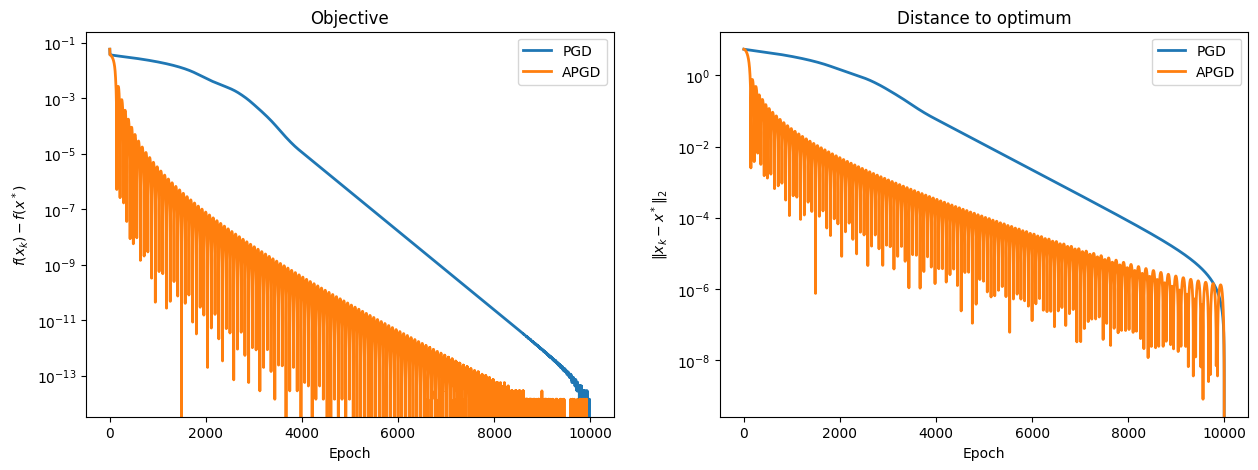

In [16]:
# TODO
x_min, _ = apgd(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter=10000, store_every=1000,
               grad_args=(X, y, tau, delta), prox_args=(lbda,))

# Run PGD
monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min, args=(X, y, lbda, tau, delta))
monitor_apgd_l2.run(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))

# END TODO

monitors = [monitor_pgd_l2, monitor_apgd_l2]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

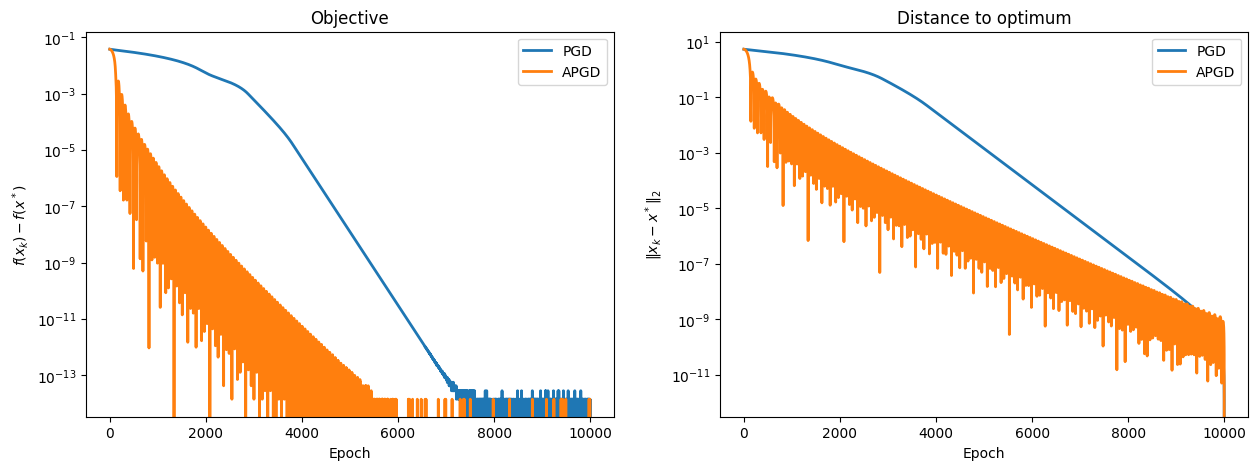

In [17]:
# TODO
x_min_l1, _ = apgd(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter=10000, store_every=1000,
               grad_args=(X, y, tau, delta), prox_args=(lbda,))
monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, tau, delta))     #need to put apgd not pgd !
monitor_apgd_l1.run(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))
# END TODO

monitors = [monitor_pgd_l1, monitor_apgd_l1]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

We can clearly see that the accelerated method (for both L1 and L2) has a faster convergence rate, but suffers from an oscillatory behavior. This was already seen in the previous labs. The reason behind this is that accelerated methods developed by Nesterov sees where it's going before applying the gradient step. This allows the model to not go 'blindly' like the gradient is telling. However when we start seeing a change of sign in the iterates we start oscillating, and this is reflected well in the error plots. One thing to notice is that APGD creaches the minimum at around 5000 epochs while PGD needs around 8500.

#### QUESTION 9
- Implement the proximal coordinate descent (PCD) and add this solver to the monitoring plots for L1 and L2 regularized models.

**Note:** You are welcome to try to use numba to get reasonable performance but don't spend too much time if you get weird numba errors.

In [18]:
# TODO
def compute_L_coords(X, delta):
    n, d = X.shape
    L = np.zeros(d + 1)
    L[0] = 1.0 / delta                      # bias
    L[1:] = (X ** 2).mean(axis=0) / delta   # weights
    return L

def prox_l1_1d(u, step, lam): ## those are 1D so that it's easier to handle for coordinate descent
    return np.sign(u) * max(abs(u) - lam * step, 0.0)

def prox_l2_1d(u, step, lam):
    return u / (1.0 + lam * step)

def pcd_solver(x_init, grad, prox, step, n_iter=100, store_every=1,
               grad_args=(), prox_args=()):
    """
    Proximal Coordinate Descent (PCD)

    Parameters
    ----------
    x_init : array
        Initial parameters (b, w).
    grad : callable
        Gradient of the smooth data-fitting term.
    prox : callable
        1D proximal operator (L1 or L2).
    step : unused
        Included for API compatibility.
    n_iter : int
        Number of epochs.
    store_every : int
        Storage frequency.
    grad_args : tuple
        (X, y, tau, delta)
    prox_args : tuple
        (lambda,)
    """

    X, y, tau, delta = grad_args
    lbda = prox_args[0]

    x = x_init.copy()
    d = x.shape[0]
    x_list = []

    # Coordinate-wise Lipschitz constants
    L = np.zeros(d)
    L[0] = 1.0 / delta                      # bias
    L[1:] = (X ** 2).mean(axis=0) / delta   # weights

    for k in range(n_iter):

        grad_full = grad(x, X, y, tau, delta)

        for j in range(d):
            step_j = 1.0 / L[j]

            if j == 0:
                # bias (never regularized)
                x[j] -= step_j * grad_full[j]
            else:
                # proximal coordinate update
                x[j] = prox(
                    x[j] - step_j * grad_full[j],
                    step_j,
                    lbda
                )

        if k % store_every == 0:
            x_list.append(x.copy())

    return x, x_list


# END TODO

In [19]:
x_min_pcd_l2, _ = pcd_solver(
    x_init,
    grad_smooth_pinball_loss,
    prox_l2_1d,
    step=None,
    n_iter=10000,
    store_every=1000,
    grad_args=(X, y, tau, delta),
    prox_args=(lbda,)
)

monitor_pcd_l2 = monitor(
    pcd_solver,
    pobj_l2,
    x_min_pcd_l2,
    args=(X, y, lbda, tau, delta)
)

monitor_pcd_l2.run(
    x_init,
    grad_smooth_pinball_loss,
    prox_l2_1d,
    step=None,
    n_iter=n_iter,
    grad_args=(X, y, tau, delta),
    prox_args=(lbda,)
)


##Comparison of the solvers :

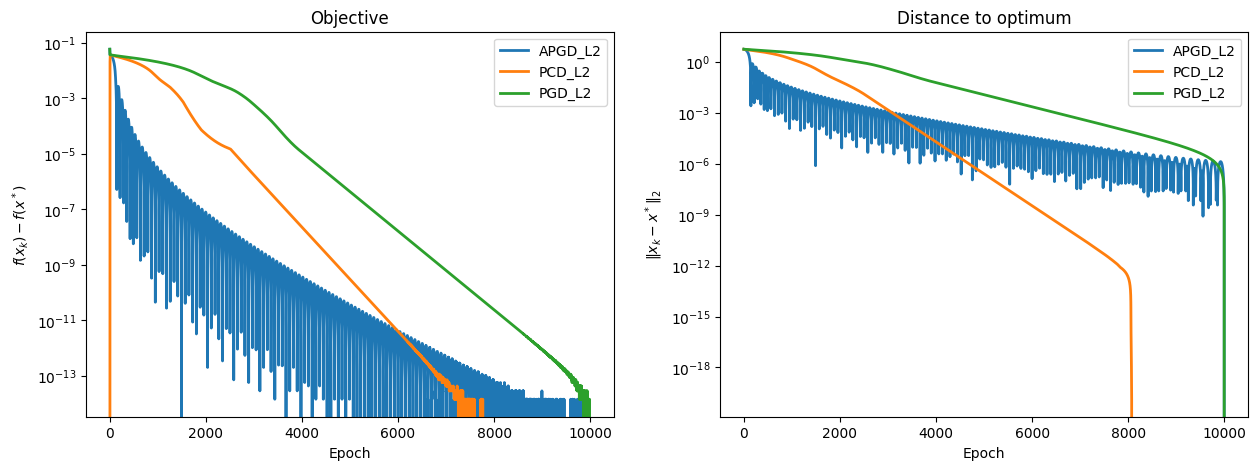

In [20]:
monitors = [monitor_apgd_l2, monitor_pcd_l2, monitor_pgd_l2]
solvers = ["APGD_L2","PCD_L2", "PGD_L2"]
plot_epochs(monitors, solvers)

In [21]:
x_min_pcd_l1, _ = pcd_solver(
    x_init,
    grad_smooth_pinball_loss,
    prox_l1_1d,
    step=None,
    n_iter=10000,
    store_every=1000,
    grad_args=(X, y, tau, delta),
    prox_args=(lbda,)
)

monitor_pcd_l1 = monitor(
    pcd_solver,
    pobj_l1,
    x_min_pcd_l1,
    args=(X, y, lbda, tau, delta)
)

monitor_pcd_l1.run(
    x_init,
    grad_smooth_pinball_loss,
    prox_l1_1d,
    step=None,
    n_iter=n_iter,
    grad_args=(X, y, tau, delta),
    prox_args=(lbda,)
)


## Comparison of the solvers :

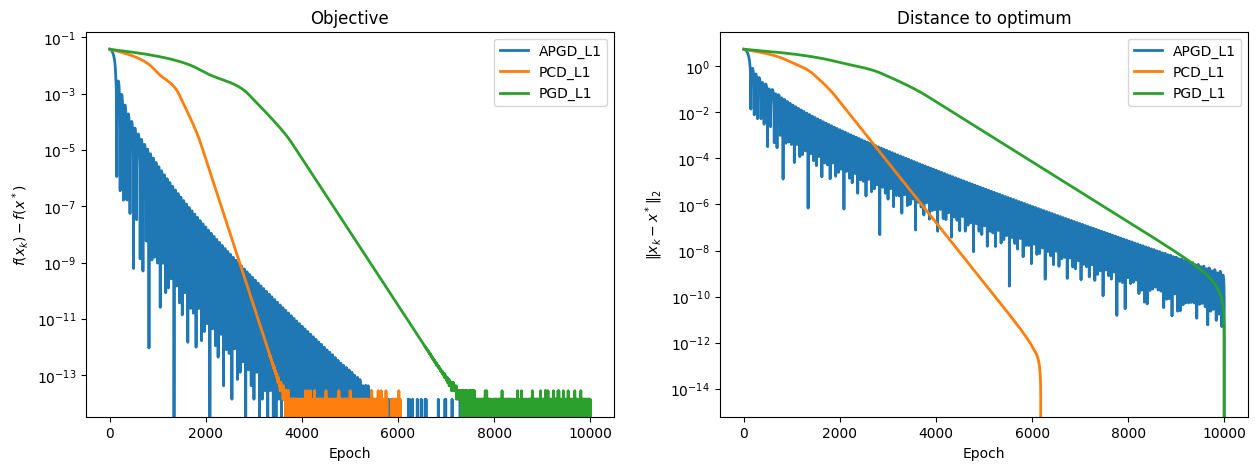

In [22]:
monitors = [monitor_apgd_l1, monitor_pcd_l1, monitor_pgd_l1]
solvers = ["APGD_L1","PCD_L1", "PGD_L1"]
plot_epochs(monitors, solvers)

We can see that PCD attains its minimum before PGD, and is much faster. APGD is faster until the middle of the road, but PCD becomes faster after 3000 epochs and doesn't suffer from oscillations like APGD. For the distance to optimum, PCD reaches the minimum before both methods and doesn't suffer from an oscillatory behavior.

#### QUESTION 10
- Compare the performance of the different solvers for different (simulated) problem sizes. You will test on a dataset with n_samples >> n_features, n_samples << n_features, and for high and low values of $\lambda$.
- What solver would you recommend for each of the 4 scenarios?

**Remark:** What is expected from you here is to provide clear and synthetic plots that show the performance of the different solvers for the different simulated datasets.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

def run_experiment(n_samples, n_features, lbda):
    # =========================
    # Data
    # =========================
    X, y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        random_state=0,
        noise=4.0,
        bias=10.0
    )

    n_samples, n_features = X.shape
    x_init = np.zeros(n_features + 1)  # [b, w]
    x_init[0] = np.mean(y)

    # Quantile regression params
    tau = 0.5
    delta = 1.0

    # Optimization params
    n_iter = 3000
    store_every_ref = 1000

    # Step size (objective averaged over samples)
    L = (np.linalg.norm(X, ord=2) ** 2) / (n_samples * delta)
    step = 1.0 / L

    regime = "N >> P" if n_samples > n_features else "N << P"

    # =========================
    # Reference solutions x_min
    # =========================
    x_min_l2, _ = apgd(
        x_init, grad_smooth_pinball_loss, prox_l2, step,
        n_iter=50000, store_every=store_every_ref,
        grad_args=(X, y, tau, delta),
        prox_args=(lbda,)
    )

    x_min_l1, _ = apgd(
        x_init, grad_smooth_pinball_loss, prox_l1, step,
        n_iter=50000, store_every=store_every_ref,
        grad_args=(X, y, tau, delta),
        prox_args=(lbda,)
    )

    # =========================
    # PGD / APGD / PCD monitors
    # =========================
    monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min_l2, args=(X, y, lbda, tau, delta))
    monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min_l2, args=(X, y, lbda, tau, delta))
    monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min_l1, args=(X, y, lbda, tau, delta))
    monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min_l1, args=(X, y, lbda, tau, delta))
    monitor_pcd_l2 = monitor(pcd_solver, pobj_l2, x_min_l2, args=(X, y, lbda, tau, delta))
    monitor_pcd_l1 = monitor(pcd_solver, pobj_l1, x_min_l1, args=(X, y, lbda, tau, delta))

    monitor_pgd_l2.run(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter,
                       grad_args=(X, y, tau, delta), prox_args=(lbda,))
    monitor_apgd_l2.run(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter,
                        grad_args=(X, y, tau, delta), prox_args=(lbda,))
    monitor_pgd_l1.run(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter,
                       grad_args=(X, y, tau, delta), prox_args=(lbda,))
    monitor_apgd_l1.run(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter,
                        grad_args=(X, y, tau, delta), prox_args=(lbda,))
    monitor_pcd_l2.run(x_init, grad_smooth_pinball_loss, prox_l2_1d,
                       step=None, n_iter=n_iter,
                       grad_args=(X, y, tau, delta), prox_args=(lbda,))
    monitor_pcd_l1.run(x_init, grad_smooth_pinball_loss, prox_l1_1d,
                       step=None, n_iter=n_iter,
                       grad_args=(X, y, tau, delta), prox_args=(lbda,))

    # =========================
    # Plot
    # =========================
    monitors = [
        monitor_pgd_l2, monitor_apgd_l2,
        monitor_pgd_l1, monitor_apgd_l1,
        monitor_pcd_l2, monitor_pcd_l1
    ]
    solvers = ["PGD-L2", "APGD-L2", "PGD-L1", "APGD-L1", "PCD-L2", "PCD-L1"]

    plot_epochs(monitors, solvers)
    plt.show()


## First scenario : N >>P and low lambda

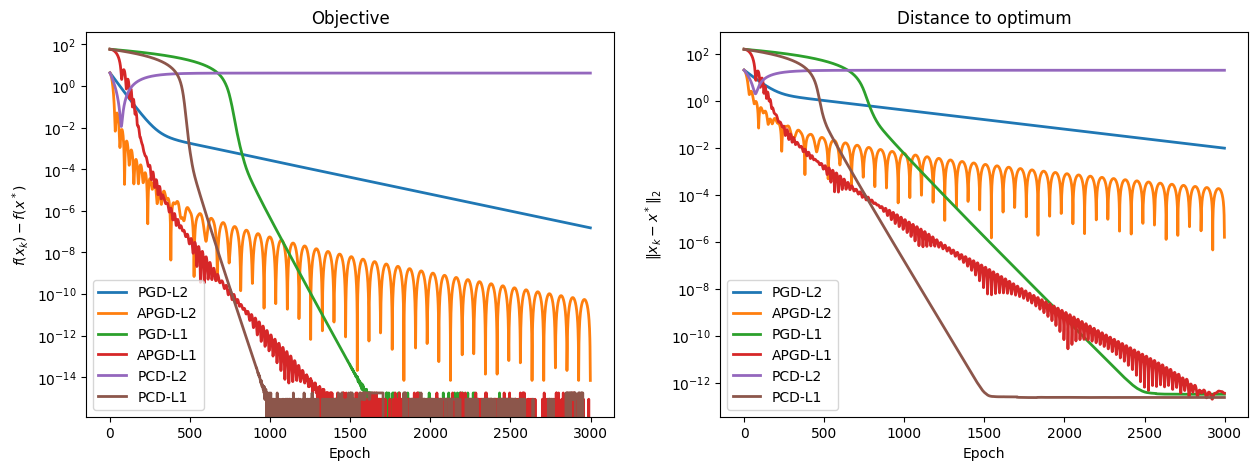

In [24]:
# N >> P, low lambda
run_experiment(1000, 100, 0.01)

## 2nd scenario : N>>P and High lambda

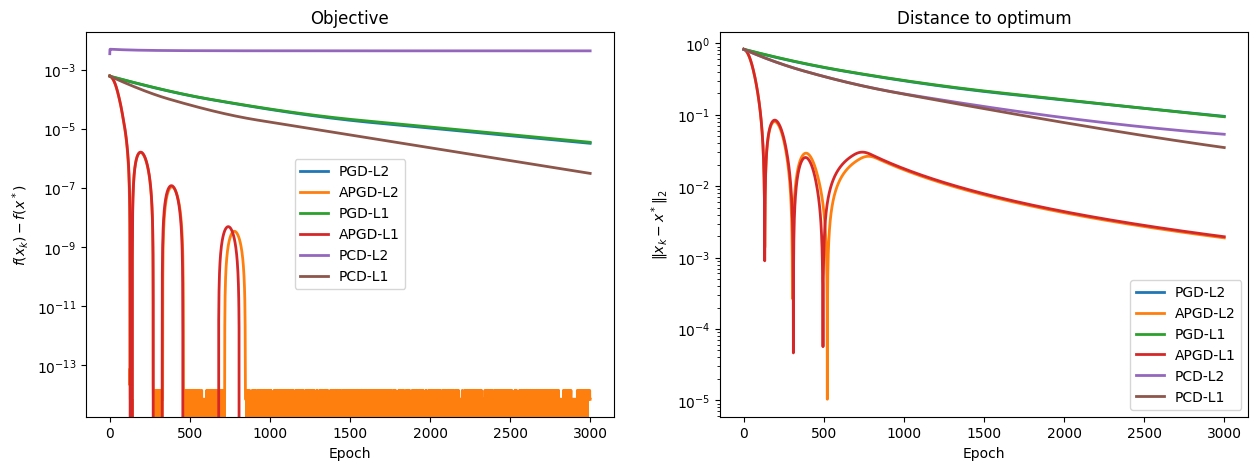

In [25]:
# N >> P, high lambda
run_experiment(1000, 100, 10.0)

## 3rd scenario : N<<P and low lambda :

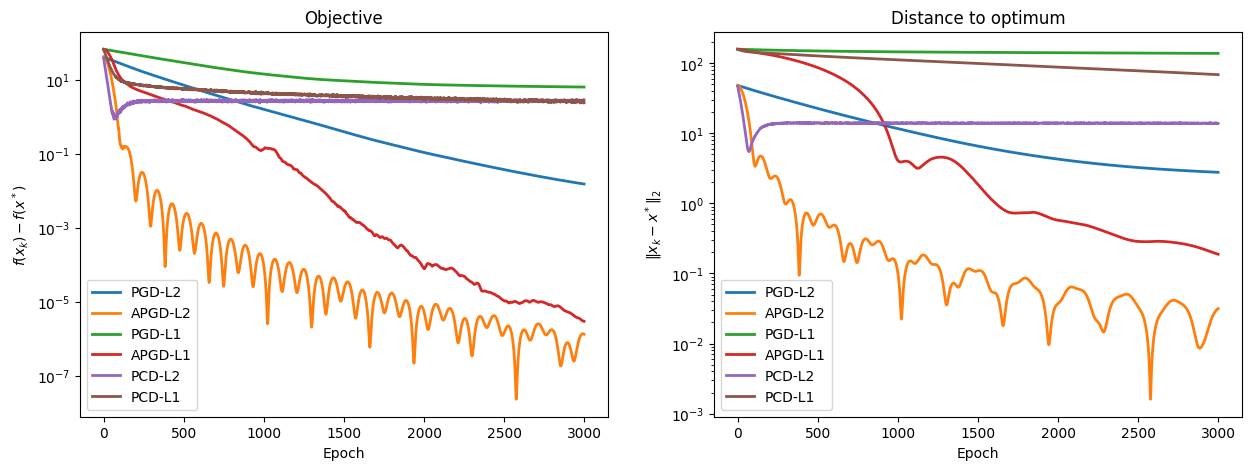

In [26]:
# N << P, low lambda
run_experiment(100, 1000, 0.01)

## 4th scenario : N<<P and high lambda :

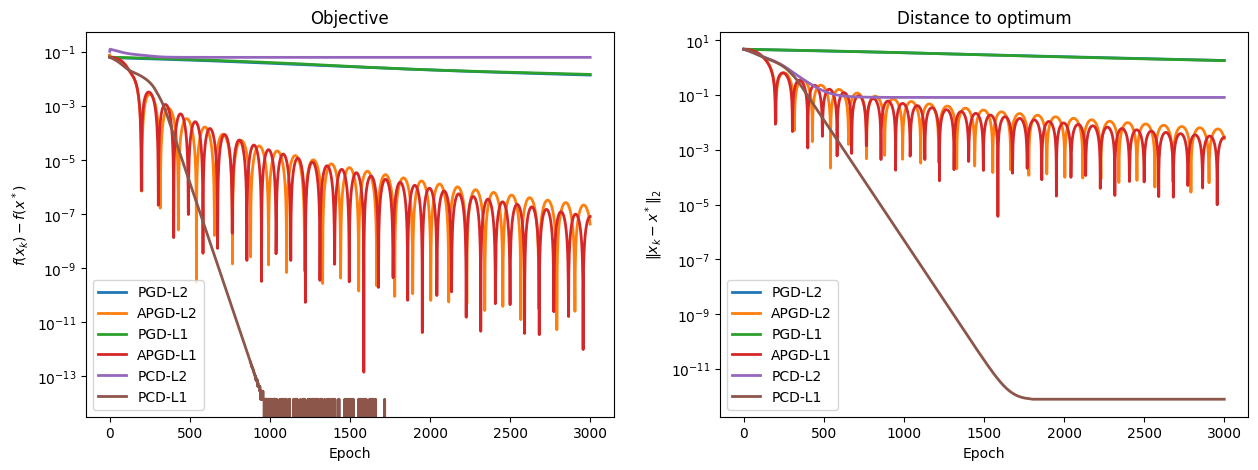

In [27]:
# N << P, high lambda
run_experiment(100, 1000, 10.0)

## Comparison and solver recommendations

**Scenario 1: $n \gg p$ and low $\lambda$**
In this "low-dimensional" case, **APGD-L1** and **PCD-L1** are the top performers. Theoretically, when $n > p$, the problem is generally well-conditioned. **APGD** wins early on because of Nesterov’s momentum: it uses previous steps to "accelerate" through flat areas of the cost function. **PCD-L1** catches up because, with few features, it can cycle through every coordinate very quickly. **PCD-L2** fails here (and everywhere else) because updating one coordinate at a time for a smooth $L_2$ penalty is just a very inefficient way to move when features are correlated.
* **Recommendation:** **APGD-L1** or **PCD-L1**.

**Scenario 2: $n \gg p$ and high $\lambda$**
With a high $\lambda$, the objective function becomes "sharper" or more strongly convex. This improves the condition number $\kappa$, which is basically the ratio of the curvature in the steepest vs. flattest directions. Accelerated methods like **APGD** are mathematically designed to exploit this, reaching a convergence rate of $O(1/k^2)$ instead of the usual $O(1/k)$ for standard PGD.
* **Recommendation:** **APGD** (either L1 or L2).

**Scenario 3: $n \ll p$ and low $\lambda$**
This is the hardest "high-dimensional" case because the problem is under-determined (too many variables, not enough data). The landscape is very flat in many directions, which is why most solvers struggle. **APGD-L2** is the most stable because the $L_2$ penalty, $\frac{\lambda}{2} \|x\|_2^2$, adds a bit of curvature (strong convexity) to an otherwise flat surface, helping the gradient descent keep its direction. **PCD** fails here because, without a strong $\lambda$ to force variables to zero, it just "zig-zags" back and forth between correlated features without making real progress.
* **Recommendation:** **APGD-L2**.

**Scenario 4: $n \ll p$ and high $\lambda$**
This is the "sparsity" scenario. **PCD-L1** is the best here because it’s a coordinate-wise method. In high dimensions with a large $L_1$ penalty, the optimal solution $x^*$ is very sparse (mostly zeros). **PCD-L1** is extremely efficient at this because its proximal step (Soft-Thresholding) sets coordinates to zero immediately. Once it identifies the "active set" (the few non-zero features), it converges much faster than gradient methods that try to update every single coordinate at every step.
* **Recommendation:** **PCD-L1**.

# Part 3: Application

You will now apply your solver to some census dataset where we aim to predict the wage of a person given some demographic and work related variables.

**Disclaimer:** This dataset is not huge and regularization makes little sense with so little features but it serves as a simple illustration.

Let's first inspect the dataset:

In [41]:
from sklearn.datasets import fetch_openml
wages = fetch_openml(name="cps_85_wages", as_frame=True)
X_df, y_df = wages["data"], wages["target"]
X_df.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,35,White,Other,Other,Married


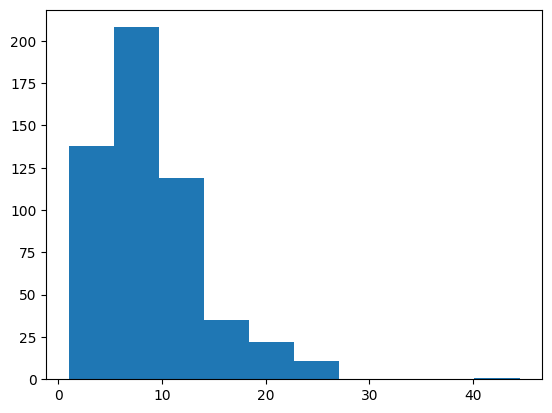

In [42]:
plt.hist(y_df);

In [43]:
X_df.dtypes

,0
EDUCATION,int64
SOUTH,category
SEX,category
EXPERIENCE,int64
UNION,category
AGE,int64
RACE,category
OCCUPATION,category
SECTOR,category
MARR,category


Now let's extract `X` taking only the numerical columns (y is already defined above) and do some basic plot:

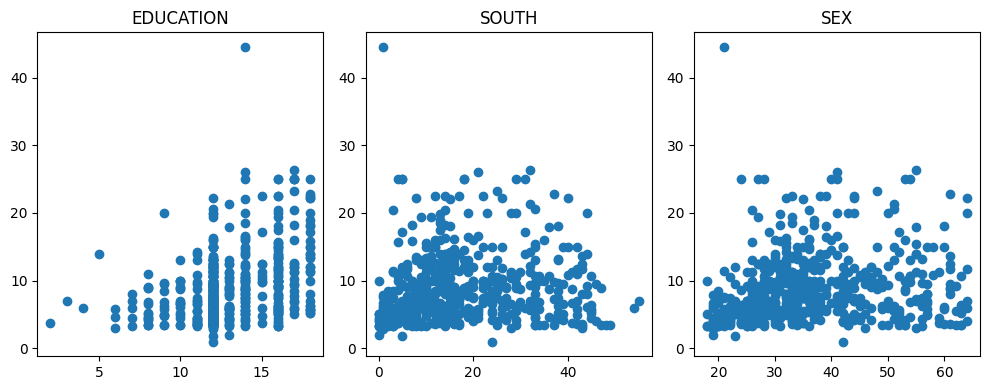

In [44]:
X_df_num = X_df.select_dtypes(include=(float, int))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
for x, col_name, ax in zip(X_df_num.values.T, X_df.columns, axes.ravel()):
    ax.plot(x, y_df, 'o')
    ax.set_title(col_name)
fig.tight_layout()

In [45]:
X = X_df_num.values
y = y_df.values
y.shape, X.shape

((534,), (534, 3))

We have now X and y!

In order to facilitate our experiment we're going to write a full scikit-learn estimator.

#### QUESTION 11
- Implement the `fit` method from the estimator in the next cell and fit the model with the different solvers you implemented above.

In [46]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import scale


class SmoothQuantileRegressor(BaseEstimator, RegressorMixin):
    """scikit-learn estimator for regression with a smoothed quantile loss.

    Parameters
    ----------
    lbda : float
        The regularization parameter
    penalty : 'l1' | 'l2'
        The type of regularization to use.
    tau : float in (0, 1)
        The quantile to predict.
    delta : float
        The smoothing parameter.
    max_iter : int
        The number of iterations / epochs to do on the data.
    solver : 'pgd' | 'apgd' | 'pcd'
        The type of algorithm to use.

    Attributes
    ----------
    coef_ : ndarray, (n_features,)
        The weights w.
    intercept_ : float
        The intercept or bias term b.
    """
    def __init__(self, lbda=1., penalty='l2', tau=0.5, delta=0.5,
                 max_iter=2000, solver='pgd'):
        self.lbda = lbda
        self.penalty = penalty
        self.tau = tau
        self.delta = delta
        self.max_iter = max_iter
        self.solver = solver
        assert self.penalty in ['l1', 'l2']
        assert self.solver in ['pgd', 'apgd', 'pcd']

    def fit(self, X, y):
        """Fit method

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
        """
        n_samples, n_features = X.shape
        # TODO
        x_init = np.zeros(n_features + 1)   # [b, w]
        x_init[0] = np.mean(y)
        # Choose proximal operator
        if self.penalty == 'l2':
          if self.solver == 'pcd':
            prox = prox_l2_1d
          else:
            prox = prox_l2
        else:
          if self.solver == 'pcd':  # 'l1'
            prox = prox_l1_1d
          else:
            prox = prox_l1

        # Step size (only needed for PGD / APGD) as the one PCD is computed inside the fct
        # Lipschitz constant of the smooth data-fit term
        L = (np.linalg.norm(X, ord=2) ** 2) / n_samples * self.delta
        step = 1.0 / L

        # Select solver
        if self.solver == 'pgd':
            x, _ = pgd(
                x_init,
                grad_smooth_pinball_loss,
                prox,
                step,
                n_iter=self.max_iter,
                grad_args=(X, y, self.tau, self.delta),
                prox_args=(self.lbda,)
            )

        elif self.solver == 'apgd':
            x, _ = apgd(
                x_init,
                grad_smooth_pinball_loss,
                prox,
                step,
                n_iter=self.max_iter,
                grad_args=(X, y, self.tau, self.delta),
                prox_args=(self.lbda,)
            )

        elif self.solver == 'pcd':
            x, _ = pcd_solver(
                x_init,
                grad_smooth_pinball_loss,
                prox,
                step=None,  # unused for PCD
                n_iter=self.max_iter,
                grad_args=(X, y, self.tau, self.delta),
                prox_args=(self.lbda,)
        )
        # END TODO
        self.params_ = x
        self.coef_ = x[1:]
        self.intercept_ = x[0]
        return self

    def predict(self, X):
        """Predict method

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_pred : ndarray, shape (n_samples,)
            The predicted target.
        """
        return np.dot(X, self.coef_) + self.intercept_


    def score(self, X, y):
        """Score using the pinball loss.

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.

        Returns
        -------
        score : float
            The negative pinball loss.
            Negative to keep the semantic that higher is better.
        """
        return -np.mean(pinball(y - self.predict(X), tau=self.tau))

lbda = 1e-4
max_iter = 1000

X_scaled = scale(X)  # standardize the features

for solver in ['pgd', 'apgd', 'pcd']:
    clf = SmoothQuantileRegressor(lbda=lbda, penalty='l2', max_iter=max_iter, solver=solver)
    clf.fit(X_scaled, y)
    print('Solver with L2: %s   \t-   Pinball : %.5f' % (solver, -clf.score(X, y)))

for solver in ['pgd', 'apgd', 'pcd']:
    clf = SmoothQuantileRegressor(lbda=lbda, penalty='l1', max_iter=max_iter, solver=solver)
    clf.fit(X_scaled, y)
    print('Solver with L1: %s   \t-   Pinball : %.5f' % (solver, -clf.score(X, y)))

Solver with L2: pgd   	-   Pinball : 33.92879
Solver with L2: apgd   	-   Pinball : 29.39856
Solver with L2: pcd   	-   Pinball : 34.39001
Solver with L1: pgd   	-   Pinball : 33.96712
Solver with L1: apgd   	-   Pinball : 9.14180
Solver with L1: pcd   	-   Pinball : 34.43065


To illustrate the predictions here is a simple plot where you should see the interval of the predictions with 3 different quantiles. Feel free to comment on what you see and go beyond this plot if you feel inspired !

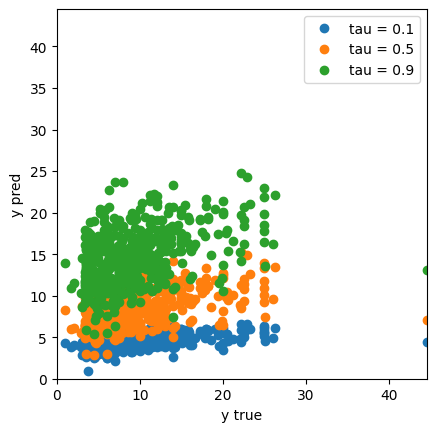

In [47]:
fig, ax = plt.subplots()
for tau in [0.1, 0.5, 0.9]:
    clf = SmoothQuantileRegressor(lbda=lbda, penalty='l2', solver="apgd", tau=tau)
    y_pred = clf.fit(X_scaled, y).predict(X_scaled)
    ax.plot(y, y_pred, 'o', label=f'tau = {tau:.1f}')
    ax.axis("square")

ax.set(xlabel="y true", ylabel="y pred", xlim=(0, np.max(y)), ylim=(0, np.max(y)))
plt.legend();

We can see that APGD-L1 achieved the lowest pinball error here. One of the reasons is that we don't suffer from ill conditioning, and we also don't have many features so coordinate based methods might not help much. The lasso regularization added sparsity which might have been relevant here.

In the plot we can see that the ordr of quantiles is respected (0.1 under 0,5 under 0.9).The predictions form horizontal bands rather than diagonals since we are predicting quantiles instead of the direct target.